In [1]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

def selectBestRegressor(X, y, cvtrain, rand_seed, arg):
    # or cv=cvtrain for initial HRI
    # cv = cvtrain # when rand_seed == 0, to get initial HRI results
    cv = KFold(n_splits=cvtrain, shuffle=True, random_state=rand_seed)

    if arg['reg'] == 'linear':
        from sklearn import linear_model
        reg = linear_model.LinearRegression()

    elif arg['reg'] == 'ridge':
        from sklearn.kernel_ridge import KernelRidge
        tuned_parameters =  [
                            {'kernel': ['rbf'],
                            'gamma': np.logspace(-1, 2, num=4),
                             'alpha': np.logspace(-9, -2, num=6)
                            },
                            {'kernel': ['linear'],
                             'alpha': np.logspace(-4, 4, num=10)
                            }
                            ]

        cvreg = GridSearchCV(KernelRidge(),
                   tuned_parameters,
                   cv=cv,
                   scoring = arg['scoring'],
                   n_jobs = arg['n_jobs']
                   )

        cvreg.fit(X, y)
        bestModel = cvreg.best_params_
        if 'gamma' not in bestModel:
            bestModel['gamma'] = 1 # will be ignored
        reg = KernelRidge(alpha = bestModel['alpha'],
                         kernel = bestModel['kernel'],
                          gamma = bestModel['gamma'])

    elif arg['reg'] == 'SVR':
        from sklearn import svm
        tuned_parameters =  [
                            {'kernel': ['rbf'],
                             'gamma': np.logspace(0, 4, num=5),
                             'C': np.logspace(-3, 2, num=6)
                            },
                            {'kernel': ['linear'],
                             'C': np.logspace(0, 6, num=7)
                            }
                            ]

        cvreg = GridSearchCV(svm.SVR(),
                   tuned_parameters,
                   cv=cv,
                   scoring = arg['scoring'],
                   n_jobs = arg['n_jobs']
                   )

        cvreg.fit(X, y)
        bestModel = cvreg.best_params_
        if 'gamma' not in bestModel:
            bestModel['gamma'] = 1 # will be ignored
        reg = svm.SVR(C = bestModel['C'],
                      kernel = bestModel['kernel'],
                      gamma = bestModel['gamma'])

    # print grid score
    if arg['verbose'] and arg['reg'] != 'linear':
##        for params, mean_score, scores in cvreg.grid_scores_:
##            print("%0.3f (+/-%0.03f) for %r"
##              % (mean_score, scores.std() / 2, params))
        print bestModel

    # train final optimal clf
    reg.fit(X, y)

    return reg

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing, model_selection, metrics
# from regressor import selectBestRegressor

In [3]:
# define dependent variable
def find_shipping(laden, day):
    if isinstance(day, basestring):
        day_obj = datetime.strptime(day, '%Y-%m-%d').date()
    else:
        day_obj = day

    laden_day = laden.loc[(laden['date_depart'] <= day_obj) & (laden['date_arrive'] > day_obj)]
    laden_day_unique = laden_day.drop_duplicates(subset='vessel', keep='first')
    total_bbls = laden_day_unique['bbls'].sum()
    total_mt = laden_day_unique['mt'].sum()
    # num_unique_vessel = len(laden_day_unique)
    # print "day %s: %i vessels moving with total tonnage %i" % (day, num_unique_vessel, total_tonnage)
    return total_bbls, total_mt

In [4]:
# define independent variable
def find_empty(ballast, laden, day):
    if isinstance(day, basestring):
        day_obj = datetime.strptime(day, '%Y-%m-%d').date()
    else:
        day_obj = day
    ballast_day = ballast.loc[(ballast['date_depart'] <= day_obj) & (ballast['date_arrive'] > day_obj)]
    num_empty_vessels = len(ballast_day)
    total_empty_tonnage = 0
    for i in ballast_day.index:
        laden_this_vessle = laden.loc[(laden['vessel']==ballast_day.loc[i,'vessel']) \
                                    & (laden['date_depart']==ballast_day.loc[i,'date_load'])].head(1)
        if len(laden_this_vessle) == 1 and not np.isnan(laden_this_vessle.iloc[0]['bbls']):
            total_empty_tonnage += laden_this_vessle.iloc[0]['bbls']
    return num_empty_vessels, total_empty_tonnage

In [5]:
def preprocess():
    # === laden data ===
    # load and process laden data
    laden_path = '../data/voyage_lpg.csv'
    laden = pd.read_csv(laden_path, sep='|')

    # convert to datetime, remove time, only keep date
    laden['date_depart'] = pd.to_datetime(laden['date_depart']).dt.date
    laden['date_arrive'] = pd.to_datetime(laden['date_arrive']).dt.date

    # === ballast data ===
    ballast_path = '../data/voyage_lpg_ballast.csv'
    ballast = pd.read_csv(ballast_path, sep='|')

    # convert to datetime
    ballast['date_depart'] = pd.to_datetime(ballast['date_depart']).dt.date
    ballast['date_arrive'] = pd.to_datetime(ballast['date_arrive']).dt.date
    ballast['date_load'] = pd.to_datetime(ballast['date_load']).dt.date

    # === intermediate output ===
    output_fn = '../output/feature.csv'

    # === processing ===
    df = pd.DataFrame(columns=['day', 'total_bbls', 'total_mt', 'num_empty_vessels', 'total_empty_tonnage'])
    sorted_unique_days = sorted(laden['date_depart'].unique())
    for i, day in enumerate(sorted_unique_days):
        if i < 1218:
            continue
        print "working on day %i / %i: %s" % (i, len(sorted_unique_days), day)
        total_bbls, total_mt = find_shipping(laden, day)
        num_empty_vessels, total_empty_tonnage = find_empty(ballast, laden, day)
        new_row = {'day': day, 'total_bbls':total_bbls, \
            'total_mt':total_mt, 'num_empty_vessels':num_empty_vessels, \
            'total_empty_tonnage':total_empty_tonnage}
        print new_row
        df = df.append(new_row, ignore_index=True)
        df.to_csv('../data/formatted.csv', index=False)

In [6]:
def format_features():
    # === load data ===
    # load formatted data
    formatted_data_path = '../data/formatted.csv'
    data = pd.read_csv(formatted_data_path)
    data['day'] = pd.to_datetime(data['day']).dt.date
    col_names = ['day', 'total_bbls']
    for dt in range(21, 28):
        col_names.append('num_empty_vessels_%i_days_ago' % dt)
    for dt in range(21, 28):
        col_names.append('total_empty_tonnage_%i_days_ago' % dt)
    df = pd.DataFrame(columns=col_names)

    for i, idx in enumerate(data.index):
        if i < 27:
            continue
        this_row = {}
        this_row['day'] = data.loc[idx]['day']
        this_row['total_bbls'] = data.loc[idx]['total_bbls']
        for dt in range(21, 28):
            this_row['num_empty_vessels_%i_days_ago' % dt] = data.iloc[i-dt]['num_empty_vessels']
            this_row['total_empty_tonnage_%i_days_ago' % dt] = data.iloc[i-dt]['total_empty_tonnage']
        # print '\n\n'
        # for key in sorted(this_row.keys()):
        #     print key, this_row[key]
        df = df.append(this_row, ignore_index=True)
    df.to_csv('../data/formatted_offset.csv', index=False)

In [7]:
def calc_features():
    formatted_offset_path = '../data/formatted_offset.csv'
    df0 = pd.read_csv(formatted_offset_path)

    # EDA, look at y
    y = df0['total_bbls'].values
    # plt.hist(y, bins=50, color='b')
    # plt.show()

    ### remove outlier from y
    print "=== remove outliers using bbls ==="
    Q1, Q3 = np.percentile(y, q=[25,75])
    IQR = Q3-Q1
    upper_fence = Q3 + 1.5*IQR
    lower_fence = Q1 - 1.5*IQR
    print 'upper_fence', upper_fence
    print 'lower_fence', lower_fence
    df_outliers = df0.loc[(df0['total_bbls'] > upper_fence) | (df0['total_bbls'] < lower_fence)]
    print "# of outliers: %i/%i" % (len(df_outliers), len(df0))
    # print df_outliers['total_bbls']
    df1 = df0.drop(df_outliers.index)

    ### remove outlier from x
    print "=== remove outliers using num_empty_vessels_27_days_ago ==="
    x = df1['num_empty_vessels_27_days_ago']
    Q1, Q3 = np.percentile(x, q=[25,75])
    IQR = Q3-Q1
    upper_fence = Q3 + 1.5*IQR
    lower_fence = Q1 - 1.5*IQR
    print 'upper_fence', upper_fence
    print 'lower_fence', lower_fence
    df1_outliers = df1.loc[(df1['num_empty_vessels_27_days_ago'] > upper_fence) |\
                           (df1['num_empty_vessels_27_days_ago'] < lower_fence)]
    print "# of outliers: %i/%i" % (len(df1_outliers), len(df1))
    # print df1_outliers['num_empty_vessels_27_days_ago']
    df2 = df1.drop(df1_outliers.index)

    ### now the final clean data
    N = len(df2)
    print "number of cleaned rows for processing: %i" % N
    print "calculating features, wait..."

    # create features on number of empty ships
    empty_vessels_names = ['num_empty_vessels_%i_days_ago'%i for i in range(21,28)]
    df2['avg_num_empty_vessels'] = df2[empty_vessels_names].mean(axis=1) 
    df2['std_num_empty_vessels'] = df2[empty_vessels_names].std(axis=1) 
    for i in df2.index:
        x = np.arange(1,8)
        y = df2.loc[i, empty_vessels_names[::-1]].values.astype(float)
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        df2.loc[i,'num_empty_vessels_slope'] = slope

    # create features on tonnage
    total_tonnage_names = ['total_empty_tonnage_%i_days_ago'%i for i in range(21,28)]
    df2['avg_total_empty_tonnage'] = df2[total_tonnage_names].mean(axis=1) 
    df2['std_total_empty_tonnage'] = df2[total_tonnage_names].std(axis=1) 
    for i in df2.index:
        x = np.arange(1,8)
        y = df2.loc[i, total_tonnage_names[::-1]].values.astype(float)
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        df2.loc[i,'total_empty_tonnage_slope'] = slope

    # create features based on random stuff, now only month
    # but we can include # of Somali pirate activites
    # month seems to not work... lol...
    # df2['month'] = pd.to_datetime(df2['day']).dt.month
    
    # drop the raw features columns
    df3 = df2.drop(empty_vessels_names+total_tonnage_names, axis=1)

    # save to csv
    df3.to_csv('../data/raw_features.csv', index=False)
    print "done, save to csv"

In [35]:
def regress():
    raw_features_path = '../data/raw_features.csv'
    df_raw = pd.read_csv(raw_features_path)

    # format X and y
    # feat_col_names = list(set(list(df_raw)) - set(['day', 'total_bbls']))
    feat_col_names = ['avg_total_empty_tonnage'] # ['avg_total_empty_tonnage', 'avg_num_empty_vessels']
    y = df_raw['total_bbls'].values
    X = df_raw[feat_col_names].values
    print "X.shape", X.shape
    print 'y.shape', y.shape
    day = df_raw['day'].values

    plot_histogram_scatter = 1
    if plot_histogram_scatter:
        # histogram of each value
        for i, feat in enumerate(feat_col_names):
            plt.figure()
            plt.hist(X[:,i], bins=50, color='b')
            plt.title('histogram of feature: %s' % feat, fontsize=15)
        plt.figure()
        plt.hist(y, bins=50, color='b')
        plt.title('histogram of y (total bbls)', fontsize=15)    

        # scatter plots
        for i, feat in enumerate(feat_col_names):
            plt.figure()
            plt.plot(X[:,i], y, 'b.')
            plt.xlabel('feature: %s' % feat, fontsize=15)
            plt.ylabel('total bbls', fontsize=15)
            plt.title('Correlation coefficient: %.2f' % np.corrcoef(X[:,i], y)[0, 1], fontsize=15)
        plt.show()

    # kfold cross validation
    kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
    para = {}
    para['scoring'] = 'neg_mean_absolute_error'
    para['reg'] = 'SVR' #['linear', 'ridge', 'SVR']
    para['verbose'] = 1
    para['n_jobs'] = -1
    r2_buf = []
    y_buf = []
    day_buf = []
    y_pred_buf = []
    for train_index, test_index in kf.split(X):
        # train-test split
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        d_train, d_test = day[train_index], day[test_index]

        # normalization
        scaler = preprocessing.StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        # get best trained regressor
        reg = selectBestRegressor(X_train, y_train, cvtrain=5,
                                  rand_seed = 0, arg = para)

        # evaluate
        y_train_pred = reg.predict(X_train)
        r2 = metrics.r2_score(y_train, y_train_pred)
        r2_buf.append(r2)
        y_test_pred = reg.predict(X_test)

        day_buf += list(d_test)
        y_buf += list(y_test)
        y_pred_buf += list(y_test_pred)


        print "average training R2 score: %.3f" % np.mean(r2_buf)
        df = pd.DataFrame(data = {'day':day_buf, 'y':y_buf, 'y_pred':y_pred_buf})
        df['day'] =pd.to_datetime(df['day'])
        df = df.sort_values(by='day',ascending=True)
        df['err'] = df['y_pred'] - df['y']
        df['abs_err'] = np.abs(df['err'])
        df['err_ratio'] = df['err'] / np.mean(df['y'])
        df['abs_err_ratio'] = np.abs(df['err_ratio'])
        df.to_csv('../data/reg_result_'+para['reg']+'.csv', index=False)

        print "mean absolute error: %.3f" % np.mean(df['abs_err'])
        print "mean absolute error ratio: %.2f%%" % (np.mean(df['abs_err_ratio']) * 100)

    plt.figure(figsize=(12,8))
    # Q-Q plot of error
    plt.subplot(221)
    stats.probplot(df['err'], dist="norm", plot=plt)

    # error vs y
    plt.subplot(222)
    plt.plot(df['y'], df['err'], 'b.')
    plt.xlabel('y', fontsize=15)
    plt.ylabel('error', fontsize=15)

    # hist of residual
    plt.subplot(223)
    plt.hist(df['err'], bins=50, color='b')
    plt.xlabel('error', fontsize=15)
    plt.ylabel('histogram', fontsize=15)

    # error vs order
    plt.subplot(224)
    plt.plot(df['err'], 'b.')
    plt.xlabel('observation order', fontsize=15)
    plt.ylabel('error', fontsize=15)
    plt.savefig('../figures/'+para['reg']+'_four_in_one.png')

    plt.figure(figsize=(12,8))
    plt.plot(df['day'], df['y'], 'b.:')
    plt.plot(df['day'], df['y_pred'], 'r.-')
    plt.xlabel('observation order', fontsize=15)
    plt.ylabel('y (blue) and y_pred (red)', fontsize=15)
    plt.title('avg train R2 score: %.3f, test relative MAE: %.2f%%' % \
            (np.mean(r2_buf), (np.mean(df['abs_err_ratio']) * 100)), fontsize=16)
    plt.savefig('../figures/'+para['reg']+'_fit.png')
    plt.show()

X.shape (1303, 1)
y.shape (1303,)


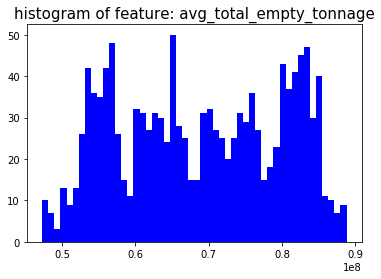

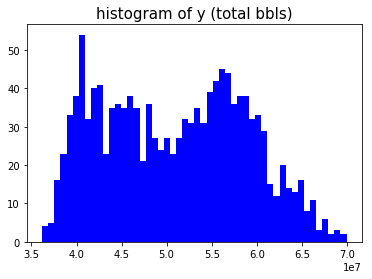

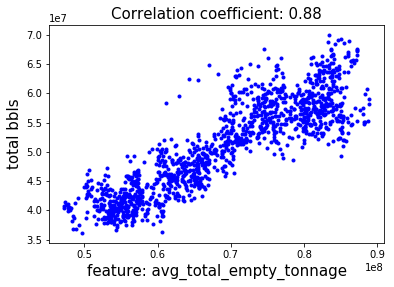

{'kernel': 'linear', 'C': 1000000.0, 'gamma': 1}
average training R2 score: 0.777
mean absolute error: 3020057.553
mean absolute error ratio: 5.91%
{'kernel': 'linear', 'C': 1000000.0, 'gamma': 1}
average training R2 score: 0.771
mean absolute error: 2957433.999
mean absolute error ratio: 5.80%
{'kernel': 'linear', 'C': 1000000.0, 'gamma': 1}
average training R2 score: 0.773
mean absolute error: 2924626.808
mean absolute error ratio: 5.78%
{'kernel': 'linear', 'C': 1000000.0, 'gamma': 1}
average training R2 score: 0.771
mean absolute error: 2903130.163
mean absolute error ratio: 5.71%
{'kernel': 'linear', 'C': 1000000.0, 'gamma': 1}
average training R2 score: 0.771
mean absolute error: 2915643.525
mean absolute error ratio: 5.73%


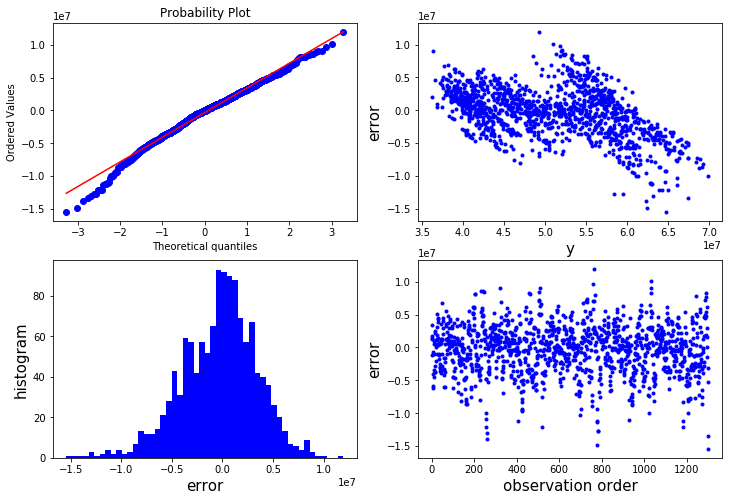

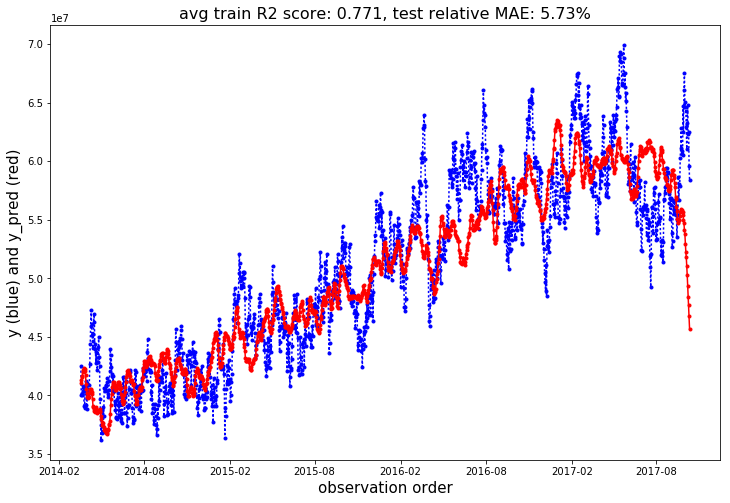

In [36]:
# if __name__ == '__main__':
# preprocess()
# format_features()
# calc_features()
regress()

In [34]:
len(X_test)/1303.0

0.1995395241749808